In [1]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

C:\Users\Mahdi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Mahdi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
labels_csv = pd.read_csv("data\\data_singl_tweet_per_line.csv")
labels_csv.head()

,user_id,label,tweet_id
0,user_1,aggressor,657684957272387584
1,user_1,aggressor,657695791134416896
2,user_1,aggressor,656838718666493952
3,user_1,aggressor,657193317709565952
4,user_1,aggressor,657688224601632768


In [3]:
tweets_csv = pd.read_csv("data\\data_tweets.csv", header=0, delimiter=",bbbbbbbbbbb", quoting=3)

for i in range(len(tweets_csv)):
    s = tweets_csv.iloc[i,1]
    s = s[1:-1]
    tweets_csv.iloc[i,1] = s

tweets_csv.head()

C:\Users\Mahdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,tweet_id,tweet
0,692398237689327616,#ProChoice #Abortion Faith and the 2016 Campai...
1,660430372501499904,#HuffPost #Tcot 3 Things to Never Say to an Al...
2,692432098309705728,#Salon #Tcot Venezuela doctors fume at officia...
3,663300853479018496,@tweetbeinghuman Men work tirelessly without t...
4,660180643637260288,#Homophobia Gay priest: The Church makes the l...


In [4]:
merged = tweets_csv.merge(labels_csv, on='tweet_id')
merged = merged.drop_duplicates()
merged = merged.reset_index(drop=True)

# remove spams
merged = merged[merged.label != 'spammer']
merged = merged.reset_index(drop=False)
merged.head()

,index,tweet_id,tweet,user_id,label
0,0,692398237689327616,#ProChoice #Abortion Faith and the 2016 Campai...,user_11,aggressor
1,1,660430372501499904,#HuffPost #Tcot 3 Things to Never Say to an Al...,user_8,aggressor
2,2,692432098309705728,#Salon #Tcot Venezuela doctors fume at officia...,user_11,aggressor
3,3,663300853479018496,@tweetbeinghuman Men work tirelessly without t...,user_2,aggressor
4,4,660180643637260288,#Homophobia Gay priest: The Church makes the l...,user_8,aggressor


In [5]:
tweets_list = merged['tweet'].tolist()
labels_list = merged['label'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [6]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [7]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [8]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [9]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [128]:
embedding_vecor_length = 200

model_embed = Sequential()
model_embed.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],
                          input_shape=(max_wordNum,),trainable=False, name='Embedding'))
model_embed.compile(optimizer='RMSprop', loss='mean_squared_error')
#print (model_embed.summary())
X_train_embedded = model_embed.predict(X_train)
X_valid_embedded = model_embed.predict(X_valid)

In [129]:
#embedding_vecor_length = 200
latent_dim = 100

inputs = Input(shape=(max_wordNum,embedding_vecor_length))

#embedding = Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],trainable=True)(inputs)

encoded = LSTM(latent_dim)(inputs) #(embedding)

decoded1 = RepeatVector(max_wordNum)(encoded)
decoded2 = LSTM(embedding_vecor_length, return_sequences=True)(decoded1)
#decoded3 = LSTM(max_wordNum, return_sequences=False)(decoded2)
#decoded3 = TimeDistributed(Dense(1))(decoded2) 
#decoded3 = Reshape((max_wordNum,))(decoded3)

sequence_autoencoder = Model(inputs, decoded2)

encoder = Model(inputs, encoded)

sequence_autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')
#sequence_autoencoder.compile(loss='binary_crossentropy', optimizer='adam')


print (sequence_autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 30, 200)           0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 100)               120400    
_________________________________________________________________
repeat_vector_29 (RepeatVect (None, 30, 100)           0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 30, 200)           240800    
Total params: 361,200
Trainable params: 361,200
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

autoencoder_train = sequence_autoencoder.fit(X_train_embedded, X_train_embedded,
                            batch_size=100,
                            epochs=20,
                            validation_data=(X_valid_embedded, X_valid_embedded)
                            ,callbacks=callbacks
                            )

Train on 1734 samples, validate on 867 samples
Epoch 1/20
1734/1734 [==============================] - 14s 8ms/step - loss: 0.0630 - val_loss: 0.0591
Epoch 2/20
1734/1734 [==============================] - 10s 6ms/step - loss: 0.0598 - val_loss: 0.0584
Epoch 3/20
1734/1734 [==============================] - 10s 6ms/step - loss: 0.0594 - val_loss: 0.0581
Epoch 4/20
1734/1734 [==============================] - 10s 6ms/step - loss: 0.0591 - val_loss: 0.0580
Epoch 5/20
1734/1734 [==============================] - 10s 6ms/step - loss: 0.0590 - val_loss: 0.0578
Epoch 6/20
1734/1734 [==============================] - 10s 6ms/step - loss: 0.0589 - val_loss: 0.0578
Epoch 7/20
1734/1734 [==============================] - 9s 5ms/step - loss: 0.0588 - val_loss: 0.0578
Epoch 8/20
1734/1734 [==============================] - 9s 5ms/step - loss: 0.0587 - val_loss: 0.0577
Epoch 9/20
1734/1734 [==============================] - 9s 5ms/step - loss: 0.0584 - val_loss: 0.0572
Epoch 10/20
1734/1734 [======

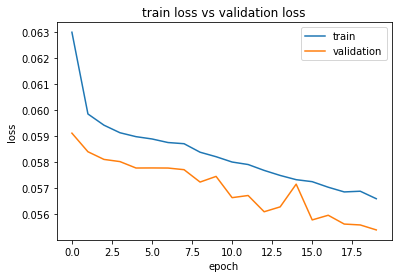

In [131]:
plt.figure()
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [135]:
X_test_embedded = model_embed.predict(X_test)
score = sequence_autoencoder.evaluate(X_test_embedded, X_test_embedded, verbose=0)
print('Test loss:', score)

Test loss: 0.055761094707223124


In [140]:
X_train_encoded = encoder.predict(X_train_embedded)
X_valid_encoded = encoder.predict(X_valid_embedded)

class_count = Y.shape[1]

model = Sequential()
model.add(Dense(20,activation='relu',name='Hidden_Layer_1', input_shape=(latent_dim,)))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None


In [143]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train_encoded, y_train, 
                    validation_data=[X_valid_encoded,y_valid],
                    epochs=100, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 1734 samples, validate on 867 samples
Epoch 1/100
1734/1734 [==============================] - 0s 36us/step - loss: 0.1207 - acc: 0.9752 - val_loss: 0.1278 - val_acc: 0.9758
Epoch 2/100
1734/1734 [==============================] - 0s 32us/step - loss: 0.1203 - acc: 0.9752 - val_loss: 0.1276 - val_acc: 0.9758
Epoch 3/100
1734/1734 [==============================] - 0s 28us/step - loss: 0.1200 - acc: 0.9752 - val_loss: 0.1274 - val_acc: 0.9758
Epoch 4/100
1734/1734 [==============================] - 0s 28us/step - loss: 0.1198 - acc: 0.9752 - val_loss: 0.1274 - val_acc: 0.9758
Epoch 5/100
1734/1734 [==============================] - 0s 31us/step - loss: 0.1194 - acc: 0.9752 - val_loss: 0.1271 - val_acc: 0.9758
Epoch 6/100
1734/1734 [==============================] - 0s 29us/step - loss: 0.1194 - acc: 0.9752 - val_loss: 0.1270 - val_acc: 0.9758
Epoch 7/100
1734/1734 [==============================] - 0s 29us/step - loss: 0.1195 - acc: 0.9752 - val_loss: 0.1270 - val_acc: 0.9758
E

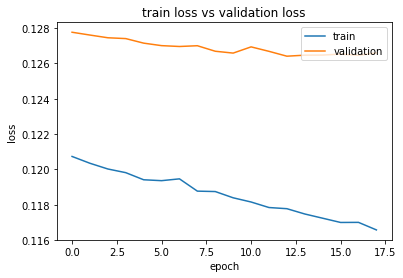

In [144]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [147]:
X_test_encoded = encoder.predict(X_test_embedded)
score = model.evaluate(X_test_encoded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11104176341113957
Test accuracy: 0.978110599078341
